## Decision Trees

In [21]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gerarDS import generate_mixed_dataset
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import learning_curve
from sklearn.metrics import zero_one_loss

### Chose the adequate DataSet

Decision trees are particularly effective when dealing with categorical and numerical data, making them an excellent choice for datasets that contain a mix of variable types. They are especially useful for classification problems, whether binary (e.g., spam detection) or multiclass (e.g., sentiment analysis). Decision trees efficiently capture interactions between features, allowing them to model complex relationships without requiring additional transformations.

Another key advantage is their ability to handle nonlinear data, as they split the dataset based on thresholds that naturally define decision boundaries. Additionally, decision trees can process missing values without the need for imputation and offer feature importance insights, helping to identify the most influential attributes. However, while they perform well on small to medium-sized datasets, they may struggle with very large datasets due to computational inefficiency and risk of overfitting.

Since decision trees can struggle with imbalanced datasets, where the majority class dominates, they should take balenced dataset to mitigate bias.

By generating a dataset with the described characteristics, we can effectively demonstrate that decision trees outperform other machine learning models in such scenarios, as they naturally leverage structure and patterns that other algorithms may struggle with.

Acrscentar alguma cena sobre noise

In [22]:
df_trees = generate_mixed_dataset(n_samples=3000, n_features=5, n_categorical=0, n_ordinal=2,
                                  n_integer=5, n_classes=2, class_balance=[0.5, 0.5], noise=0.2,
                                  dataset_type='blobs', random_state=42)

df_trees.head()

,Continuous_1,Continuous_2,Continuous_3,Continuous_4,Continuous_5,Ordinal_1,Ordinal_2,Integer_1,Integer_2,Integer_3,Integer_4,Integer_5,Target
0,-1.901560,10.457411,37.454012,95.071431,73.199394,5,2,42,68,62,92,9,0
1,5.431477,2.500271,59.865848,15.601864,15.599452,4,5,12,92,4,57,58,1
2,-2.893920,9.617381,5.808361,86.617615,60.111501,1,1,75,58,76,85,14,0
3,-1.059006,10.046643,70.807258,2.058449,96.990985,2,1,76,0,37,52,51,0
4,7.974327,5.019647,83.244264,21.233911,18.182497,1,1,0,10,57,39,85,1


In [23]:
X = df_trees.drop(columns=["Target"])
y = df_trees["Target"]

Create a DS with the same structure but with different values to test our classifier.

In [24]:
ds_test= generate_mixed_dataset(n_samples=2000, n_features=5, n_categorical=0, n_ordinal=2,
                                  n_integer=5, n_classes=2, class_balance=[0.5, 0.5], noise=0.2,
                                  dataset_type='blobs', random_state=42)

X_test = ds_test.drop(columns=["Target"])
y_test = ds_test["Target"]

### Full Tree

[Text(0.5208333333333334, 0.9375, 'x[1] <= 5.439\ngini = 0.5\nsamples = 3000\nvalue = [1500, 1500]'),
 Text(0.21666666666666667, 0.8125, 'x[0] <= -0.425\ngini = 0.055\nsamples = 1486\nvalue = [42, 1444]'),
 Text(0.13333333333333333, 0.6875, 'x[1] <= 3.125\ngini = 0.169\nsamples = 43\nvalue = [39, 4]'),
 Text(0.06666666666666667, 0.5625, 'x[8] <= 51.5\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.03333333333333333, 0.4375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.1, 0.4375, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.2, 0.5625, 'x[3] <= 3.436\ngini = 0.05\nsamples = 39\nvalue = [38, 1]'),
 Text(0.16666666666666666, 0.4375, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.23333333333333334, 0.4375, 'gini = 0.0\nsamples = 38\nvalue = [38, 0]'),
 Text(0.3, 0.6875, 'x[1] <= 4.865\ngini = 0.004\nsamples = 1443\nvalue = [3, 1440]'),
 Text(0.26666666666666666, 0.5625, 'gini = 0.0\nsamples = 1394\nvalue = [0, 1394]'),
 Text(0.3333333333333333, 0.5625, 'x[1] <= 4.86

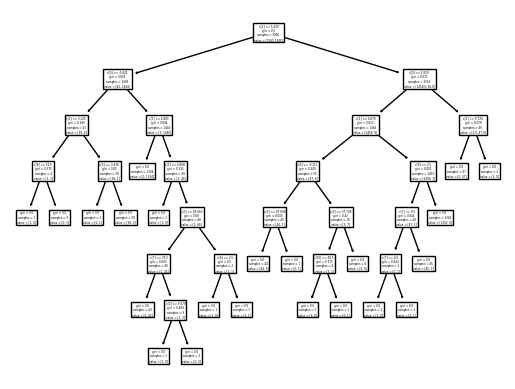

In [25]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X, y)
tree.plot_tree(dtc)

### Pruned Trees

#### Get best pruning

One limitation of decision trees is their tendency to overfit, capturing noise rather than meaningful patterns, especially when the tree grows too deep. To counteract this, we can apply pruning techniques.

Pre-pruning (early stopping) restricts tree growth using constraints like maximum depth or minimum samples per leaf, ensuring that only meaningful splits occur. Post-pruning, on the other hand, involves growing the tree fully and then removing less important branches based on validation performance. Both methods improve generalization, preventing the model from memorizing data-specific noise.

By generating a dataset and applying pruning, we can empirically demonstrate that pruned decision trees generalize better, maintaining high accuracy while avoiding overfitting. This will further reinforce the argument that decision trees are well-suited for datasets with structured, mixed-variable data.

For this study we will use Minimal Cost-Complexity Pruning, an algorithm that is parameterized by alfa >=0 - the complexity parameter. The complexity parameter is used to define the cost-complexity measure of a given tree.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

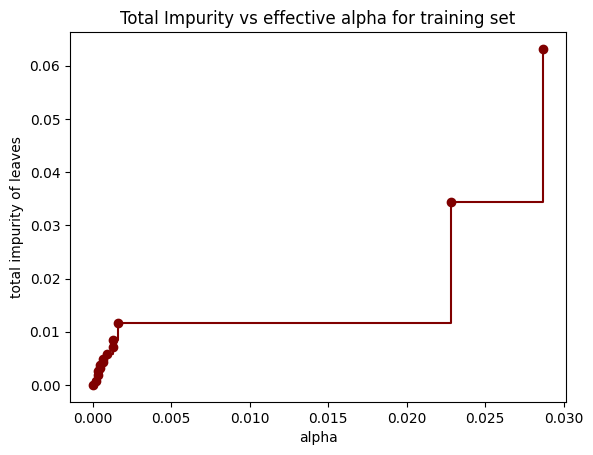

In [43]:
path = dtc.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post", color="maroon")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [44]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

print(ccp_alphas)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post", color="maroon")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post", color="darkslateblue")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

AttributeError: 'DecisionTreeClassifier' object has no attribute 'DecisionTreeClassifier'

Testar como varia a accuracy dependendo do alfa quando apresentado ao test set.

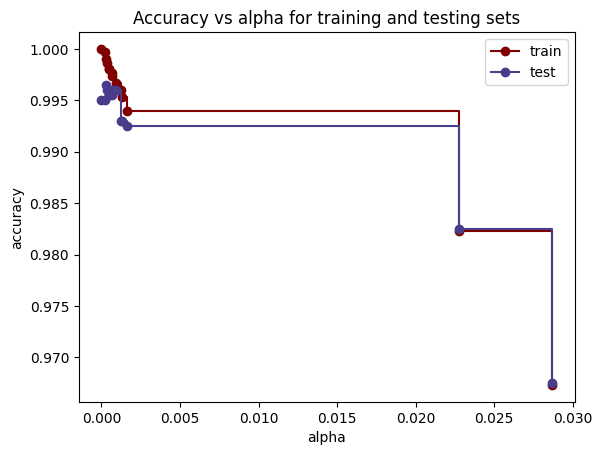

In [ ]:
train_scores = [clf.score(X, y) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post", color="maroon")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post", color="darkslateblue")
ax.legend()
plt.show()

By analyzing these graphics we conclude that these are the alfas worth testing:

In [ ]:
ccp_alpha_1 =  0.025
ccp_alpha_2 = 0.0010

#### Pruned tree #1

[Text(0.4, 0.8333333333333334, 'x[1] <= 5.439\ngini = 0.5\nsamples = 3000\nvalue = [1500, 1500]'),
 Text(0.2, 0.5, 'gini = 0.055\nsamples = 1486\nvalue = [42, 1444]'),
 Text(0.6, 0.5, 'x[0] <= 2.829\ngini = 0.071\nsamples = 1514\nvalue = [1458.0, 56.0]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.012\nsamples = 1465\nvalue = [1456, 9]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.078\nsamples = 49\nvalue = [2.0, 47.0]')]

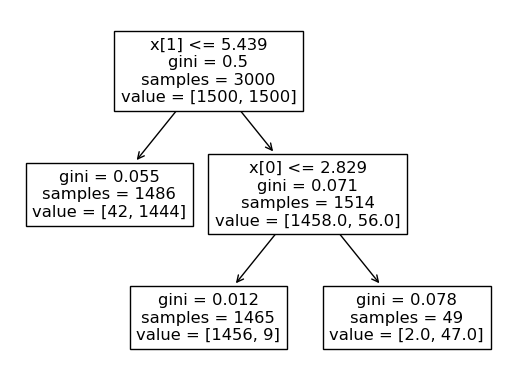

In [ ]:
dtcp1 = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha_1)
dtcp1 = dtcp1.fit(X, y)
tree.plot_tree(dtcp1)

#### Pruned tree #2

[Text(0.4583333333333333, 0.9, 'x[1] <= 5.439\ngini = 0.5\nsamples = 3000\nvalue = [1500, 1500]'),
 Text(0.25, 0.7, 'x[0] <= -0.425\ngini = 0.055\nsamples = 1486\nvalue = [42, 1444]'),
 Text(0.16666666666666666, 0.5, 'x[1] <= 3.125\ngini = 0.169\nsamples = 43\nvalue = [39, 4]'),
 Text(0.08333333333333333, 0.3, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.25, 0.3, 'gini = 0.05\nsamples = 39\nvalue = [38, 1]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.004\nsamples = 1443\nvalue = [3, 1440]'),
 Text(0.6666666666666666, 0.7, 'x[0] <= 2.829\ngini = 0.071\nsamples = 1514\nvalue = [1458.0, 56.0]'),
 Text(0.5, 0.5, 'x[1] <= 6.079\ngini = 0.012\nsamples = 1465\nvalue = [1456, 9]'),
 Text(0.4166666666666667, 0.3, 'x[0] <= -0.111\ngini = 0.249\nsamples = 55\nvalue = [47, 8]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.043\nsamples = 45\nvalue = [44, 1]'),
 Text(0.5, 0.1, 'gini = 0.42\nsamples = 10\nvalue = [3, 7]'),
 Text(0.5833333333333334, 0.3, 'gini = 0.001\nsamples = 1410\nvalue = [14

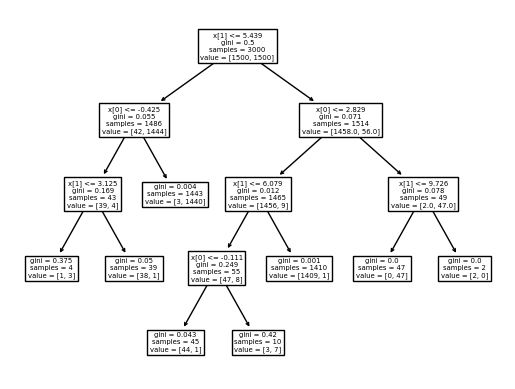

In [ ]:
dtcp2 = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha_2)
dtcp2 = dtcp2.fit(X, y)
tree.plot_tree(dtcp2)

### Comparing trees

#### Learning Curve

In [32]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="maroon")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation score", color="darkslateblue")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

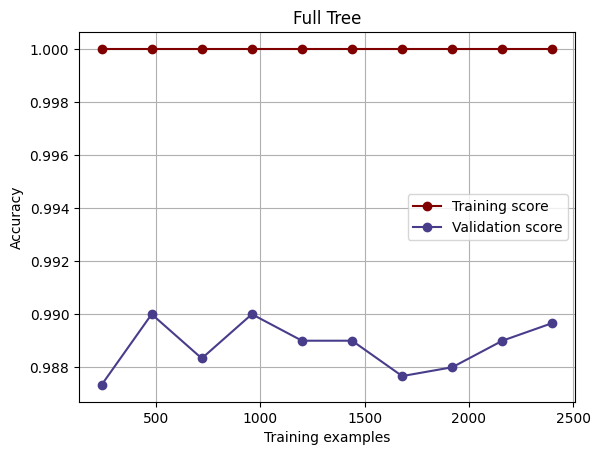

In [33]:
plot_learning_curve(dtc, X, y, "Full Tree")

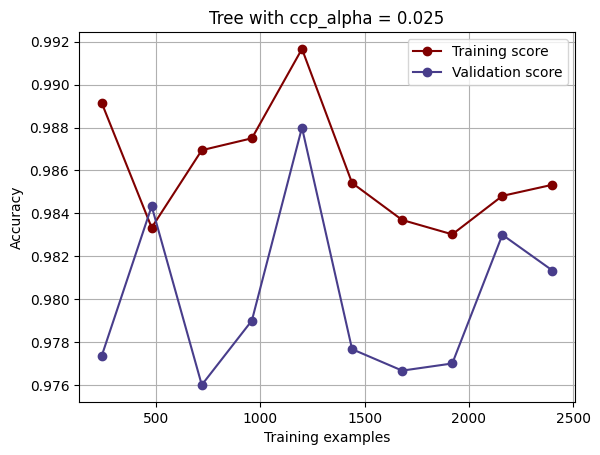

In [34]:
plot_learning_curve(dtcp1, X, y, "Tree with ccp_alpha = 0.025")

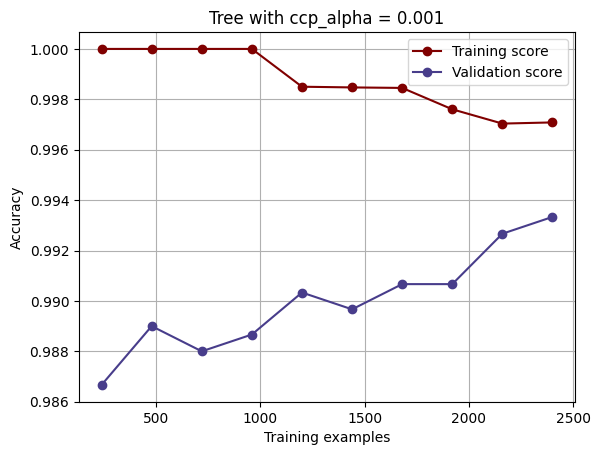

In [35]:
plot_learning_curve(dtcp2, X, y, "Tree with ccp_alpha = 0.001")

#### Bias, Variance and Total Loss

Convert dataset into numpy variables

In [36]:
X_np = X.values 
y_np = y.values  

X_np_test = X_test.values 
y_np_test = y_test.values  


Calculate the Loss, Bias and Variance for all trees. For comparison, the bias-variance decomposition of a bagging classifier, which should intuitively have a lower variance compared than a single decision tree

In [ ]:
tree_names = ['Full Tree', 'Tree ccp_alpha = 0.025', 'Tree ccp_alpha = 0.001']
biases = []
variances = []
losses = []

for i, tree in enumerate([dtc, dtcp1, dtcp2], start=1):
    avg_loss, bias, var = bias_variance_decomp(
        tree, X_np, y_np, X_np_test, y_np_test,
        loss='0-1_loss', random_seed=13
    )
    biases.append(bias)
    variances.append(var)
    losses.append(avg_loss)

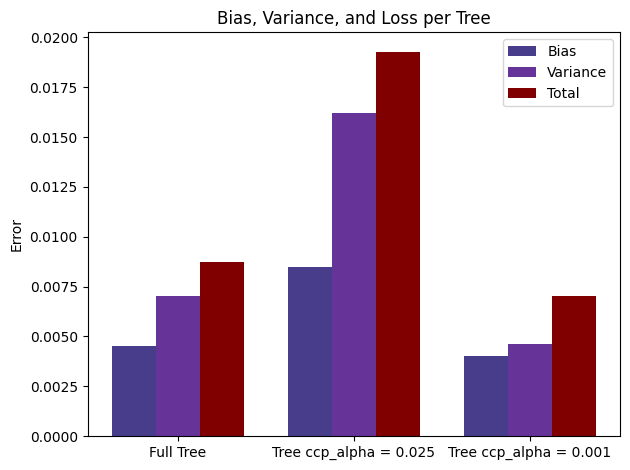

In [42]:
x = np.arange(3)
width = 0.25

plt.bar(x - width, biases, width, label='Bias', color="darkslateblue")
plt.bar(x, variances, width, label='Variance', color="rebeccapurple")
plt.bar(x + width, losses, width, label='Total', color="maroon")

plt.xticks(x, tree_names)
plt.ylabel('Error')
plt.title('Bias, Variance, and Loss per Tree')
plt.legend()
plt.tight_layout()
plt.show()


#### Cross-Validation Results

In [39]:
cv1=cross_val_score(dtc, X_test, y_test, cv=8)
cv2=cross_val_score(dtcp1, X_test, y_test, cv=8)
cv3=cross_val_score(dtcp2, X_test, y_test, cv=8)

df_cv_scores = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(8)],
    'Full Tree': cv1,
    'Tree w/ ccp_alpha 0.025': cv2,
    'Tree w/ ccp_alpha 0.001': cv3
})

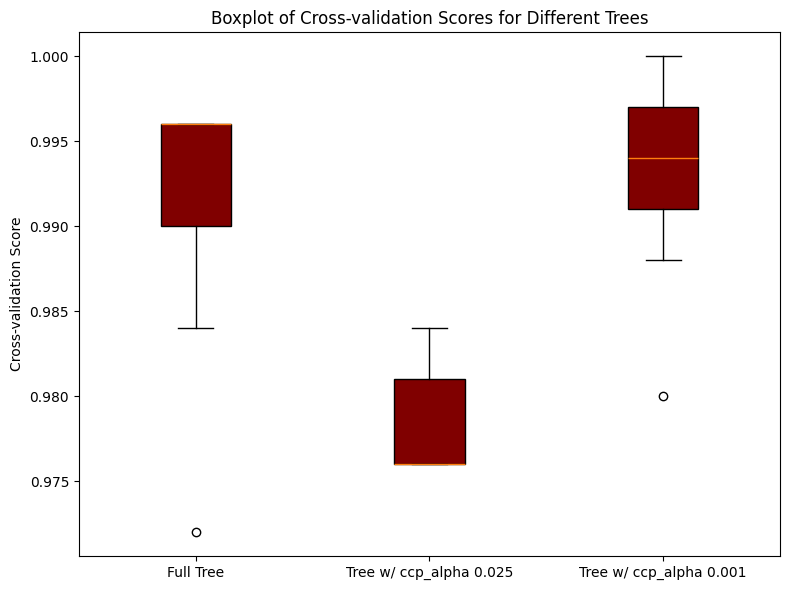

In [40]:
plt.figure(figsize=(8, 6))
plt.boxplot([cv1, cv2, cv3], labels=['Full Tree', 'Tree w/ ccp_alpha 0.025', 'Tree w/ ccp_alpha 0.001'], 
            patch_artist=True, boxprops=dict(facecolor='maroon'))
plt.ylabel('Cross-validation Score')
plt.title('Boxplot of Cross-validation Scores for Different Trees')
plt.tight_layout()
plt.show()


### Random Forests

While decision trees are powerful, they can be unstable—small changes in the data can lead to a completely different tree structure. This instability makes them sensitive to variations, which can reduce consistency in predictions. Random Forest addresses this issue by combining multiple decision trees, reducing overfitting and increasing robustness.

As an ensemble method, Random Forest builds multiple trees on different subsets of data and averages their predictions. This reduces variance and enhances model stability. Additionally, it provides feature importance rankings, making it valuable for data interpretation.
By comparing our dataset’s performance using a single decision tree versus Random Forest, we can prove that while Random Forest improves stability and accuracy, decision trees remain the best choice for structured data with strong feature interactions. This will further support our hypothesis that decision trees are optimal for the dataset we generate.

### Como se comporta em outros tipos de algoritmos de ML

By designing a dataset with these characteristics and testing it across different models, we can demonstrate that decision trees outperform other machine learning models for structured, mixed-type data. Pruning enhances their generalization ability, and comparing results with Random Forest will solidify our understanding of when decision trees work best and when ensemble methods provide additional benefits.


### Bibliografia/Webgrafia:

* https://www.quora.com/What-types-of-data-sets-are-appropriate-for-decision-tree
* https://www.stratascratch.com/blog/tree-based-models-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
* https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/

### Info original

Decision Trees:
Why They Work Best for Certain Data and Proving Their Strength

    1. Categorical and Numerical Data: Decision trees can handle both categorical and numerical data, making them suitable for data sets with a mix of variable types. They can split the data based on categorical attributes and apply numerical thresholds for numeric attributes.
    2. Classification Problems: Decision trees are often used for classification tasks, where the goal is to predict a categorical target variable. For example, they are commonly used in spam email detection, sentiment analysis, and medical diagnosis.
    3. Binary and Multiclass Classification: Decision trees can handle both binary classification (two classes) and multiclass classification (more than two classes). They can be adapted to predict multiple classes by using techniques like one-hot encoding.
    4. Data with Interactions: Decision trees are good at capturing interactions between features. If the relationships between variables are complex and involve multiple interactions, decision trees can be effective.
    5. Nonlinear Data: Decision trees can model nonlinear relationships between features and the target variable. They can create splits that capture nonlinear patterns in the data.
    6. Mixed Data: Data sets with mixed types of features, including both categorical and numerical, are suitable for decision trees. Decision trees can handle such data by choosing appropriate split criteria.
    7. Highly Interpretability: If interpretability and transparency are crucial, decision trees are a preferred choice. The tree structure is easy to understand, and it allows users to trace the decision-making process.
    8. Small to Medium-sized Data Sets: Decision trees are efficient for relatively small to medium-sized data sets. For very large data sets, they may become computationally expensive and may not perform as well as some other algorithms.
    9. Feature Importance: Decision trees provide a measure of feature importance, which can help identify which features have the most influence on the target variable. This is valuable for feature selection and understanding the data.
    10. Ensemble Methods: Decision trees can serve as base models in ensemble methods like Random Forests and Gradient Boosting, which often yield even better performance by combining multiple trees.
    11. Imbalanced Data: While decision trees can handle imbalanced datasets, care must be taken to ensure that the model does not become biased toward the majority class.
    12. Large Datasets: Decision trees can scale to large datasets, but performance may degrade if the tree becomes too deep, leading to overfitting.
    13. Data with Missing Values: Decision trees can handle missing values, as they can make splits based on available data.
    14. Overfitting: Decision trees can easily overfit if not pruned or constrained, so it’s important to monitor performance on validation data.
    15. Interpretability: One of the strengths of decision trees is their interpretability, making them useful in applications where understanding the decision-making process is crucial.
    16. Biased Trees with Imbalanced Data: If the training data is imbalanced (i.e., some classes are underrepresented), the decision tree might become biased towards the dominant class. This bias can skew the predictions, favoring the majority class at the expense of the minority class.
    17. Sensitivity to Small Changes in Data: Decision trees can be quite sensitive to small changes in the training data. A slight change can lead to a significantly different tree structure. This lack of stability can be a concern in dynamic environments where data changes frequently.

Minimal Cost-Complexity Pruning: 